## Evaluatin of OPE estimators (Part 1; easy setting)

In [86]:
import time

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_polynomial_reward_function,
    polynomial_behavior_policy
)
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    InverseProbabilityWeightingTuning as CIPS,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DirectMethod as DM,
    DoublyRobust as DR,
    DoublyRobustWithShrinkageTuning as DRos,
    SubGaussianDoublyRobustTuning as DRlam,
)
from obp.utils import softmax

from dataset import SyntheticBanditDataset
from dataset import gen_eps_greedy

In [87]:
print(obp.__version__)

0.5.4


In [88]:
## configurations
num_runs = 20
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [89]:
## define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    beta=1, 
    reward_function=logistic_polynomial_reward_function,
    behavior_policy_function=polynomial_behavior_policy,
    random_state=12345,
)
### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [90]:
## evaluation policy
action_dist_ipw_test = gen_eps_greedy(
    expected_reward=test_bandit_data["expected_reward"],
    is_optimal=True,
    eps=0.1,
)

policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [91]:
## evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## make decisions on validation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ## OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345),
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )

        lambdas1 = [1e1]#, 5e2, 1e3, 5e3, 1e4, 5e4]
        lambdas2 = [1e-2]#, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                IPS(estimator_name="IPS"), 
                DM(estimator_name="DM"), 
                CIPS(lambdas=[1, 5, 10, 50], tuning_method="mse", estimator_name="CIPS"), 
                SNIPS(estimator_name="SNIPS"),
                DR(estimator_name="DR"), 
                DRos(lambdas=[100, 500, 1000, 5000], tuning_method="mse", estimator_name="DRos"), 
                DRlam(lambdas=lambdas2, tuning_method="mse", estimator_name="DRlam"), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ## maximum importance weight in the validation data
    ### a larger value indicates that the logging and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ## summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 20/20 [00:01<00:00, 12.31it/s]


maximum importance weight=17.22798



num_data=200...: 100%|██████████| 20/20 [00:01<00:00, 13.85it/s]


maximum importance weight=35.73111



num_data=400...: 100%|██████████| 20/20 [00:01<00:00, 13.39it/s]


maximum importance weight=18.44534



num_data=800...: 100%|██████████| 20/20 [00:01<00:00, 10.92it/s]


maximum importance weight=32.64578



num_data=1600...: 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


maximum importance weight=26.59619



num_data=3200...: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


maximum importance weight=31.18771



num_data=6400...: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


maximum importance weight=36.53482



num_data=12800...: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


maximum importance weight=60.49691



num_data=25600...: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


maximum importance weight=147.79573



num_data=51200...: 100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


maximum importance weight=89.46471



## Visualize Results

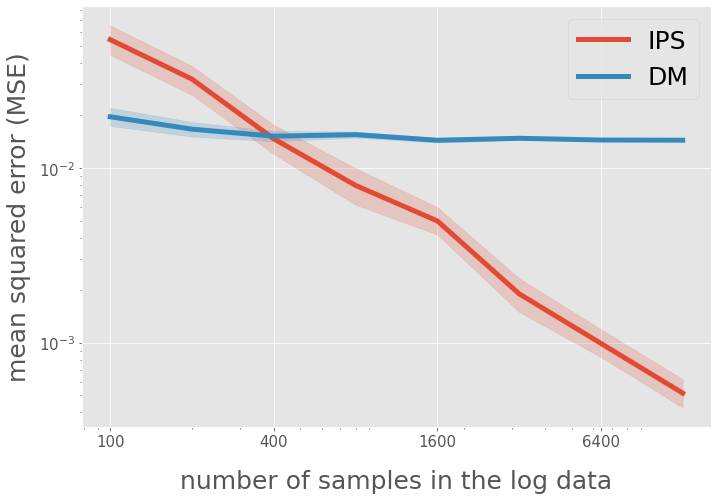

In [80]:
# figure configs
query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query("(est == 'DM' or est == 'IPS') and num_data <= 12800"),
)
# title and legend
ax.legend(["IPS", "DM"], loc="upper right", fontsize=25)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

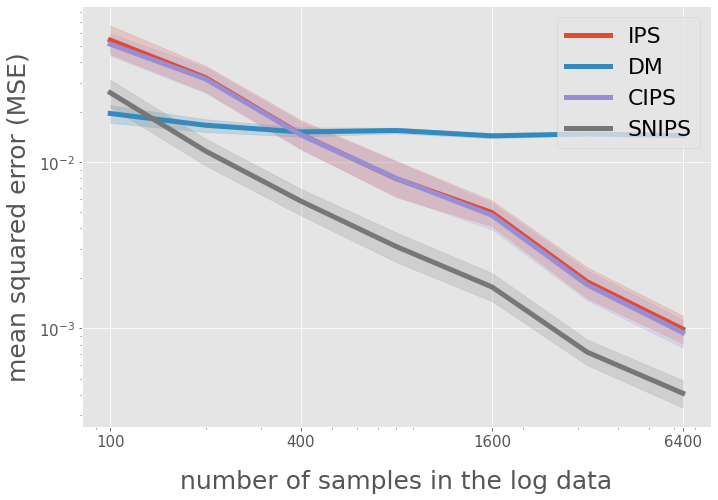

In [81]:
# figure configs
query = "(est == 'DM' or est == 'CIPS' or est == 'IPS' or est == 'SNIPS')" 
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

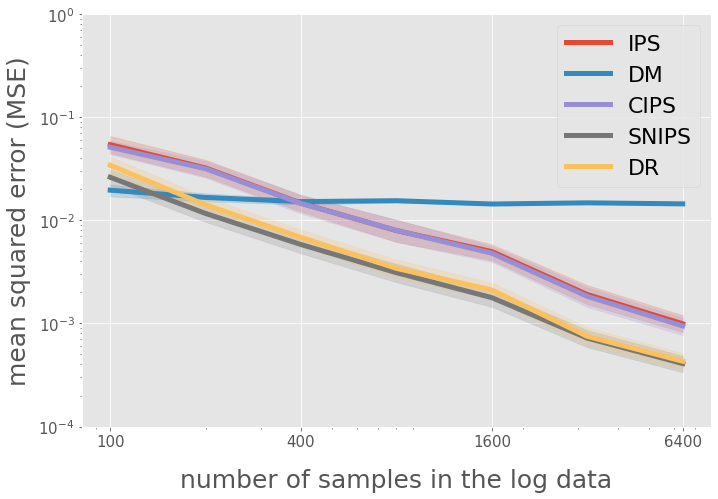

In [77]:
# figure configs
query = "(est == 'DM' or est == 'IPS' or est == 'SNIPS' or est == 'CIPS' or est == 'DR')"
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots( , tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

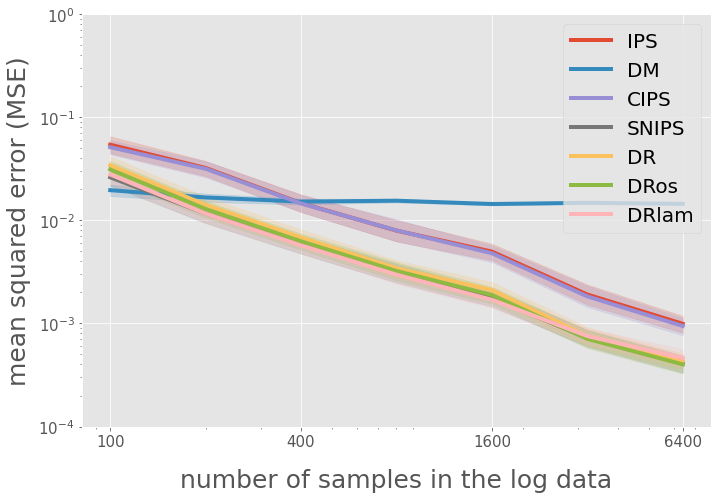

In [78]:
# figure configs
query = "num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=4,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos", "DRlam"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

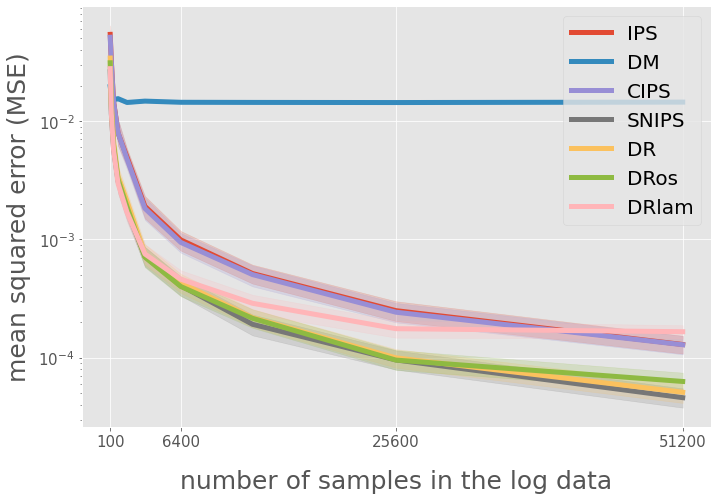

In [79]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos", "DRlam"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)